In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

def auc_scorer(clf, X, y, model): # Helper function to plot the ROC curve
    if model=='RF':
        fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1])
    elif model=='SVM':
        fpr, tpr, _ = roc_curve(y, clf.decision_function(X))
    roc_auc = auc(fpr, tpr)

    plt.figure()    # Plot the ROC curve
    plt.plot(fpr, tpr, label='ROC curve from '+model+' model (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr,roc_auc


In [3]:
df = pd.read_csv('C:/Users/91967/Downloads/kidney_disease.csv')

In [4]:
df.head(5)

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


# Pre processing the data


# Renaming all the values to binary either 0 or 1

In [5]:
df[['htn','dm','cad','pe','ane']] = df[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})
df[['rbc','pc']] = df[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})
df[['pcc','ba']] = df[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})
df[['appet']] = df[['appet']].replace(to_replace={'good':1,'poor':0,'no':np.nan})
df['classification'] = df['classification'].replace(to_replace={'ckd':1.0,'ckd\t':1.0,'notckd':0.0,'no':0.0})
df.rename(columns={'classification':'class'},inplace=True)

In [6]:
df['pe'] = df['pe'].replace(to_replace='good',value=0) # Not having pedal edema is good
df['appet'] = df['appet'].replace(to_replace='no',value=0)
df['cad'] = df['cad'].replace(to_replace='\tno',value=0)
df['dm'] = df['dm'].replace(to_replace={'\tno':0,'\tyes':1,' yes':1, '':np.nan})
df.drop('id',axis=1,inplace=True)

In [7]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,0.0,0.0,0.0,121.0,...,44,7800,5.2,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,7.0,50.0,1.020,4.0,0.0,NaN,0.0,0.0,0.0,NaN,...,38,6000,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,...,31,7500,NaN,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,...,32,6700,3.9,1.0,0.0,0.0,0.0,1.0,1.0,1.0
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,...,35,7300,4.6,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# Dropping Nan values

In [8]:
df2=df.dropna(axis=0)
df2['class'].value_counts()

0.0    115
1.0     43
Name: class, dtype: int64

In [10]:
df2.iloc[:,:-1]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,...,11.2,32,6700,3.9,1.0,0.0,0.0,0.0,1.0,1.0
9,53.0,90.0,1.020,2.0,0.0,1.0,1.0,1.0,0.0,70.0,...,9.5,29,12100,3.7,1.0,1.0,0.0,0.0,0.0,1.0
11,63.0,70.0,1.010,3.0,0.0,1.0,1.0,1.0,0.0,380.0,...,10.8,32,4500,3.8,1.0,1.0,0.0,0.0,1.0,0.0
14,68.0,80.0,1.010,3.0,2.0,0.0,1.0,1.0,1.0,157.0,...,5.6,16,11000,2.6,1.0,1.0,1.0,0.0,1.0,0.0
20,61.0,80.0,1.015,2.0,0.0,1.0,1.0,0.0,0.0,173.0,...,7.7,24,9200,3.2,1.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,140.0,...,15.7,47,6700,4.9,0.0,0.0,0.0,1.0,0.0,0.0
396,42.0,70.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,75.0,...,16.5,54,7800,6.2,0.0,0.0,0.0,1.0,0.0,0.0
397,12.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,100.0,...,15.8,49,6600,5.4,0.0,0.0,0.0,1.0,0.0,0.0
398,17.0,60.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,114.0,...,14.2,51,7200,5.9,0.0,0.0,0.0,1.0,0.0,0.0


# Getting co relation rate/factor for the variables  

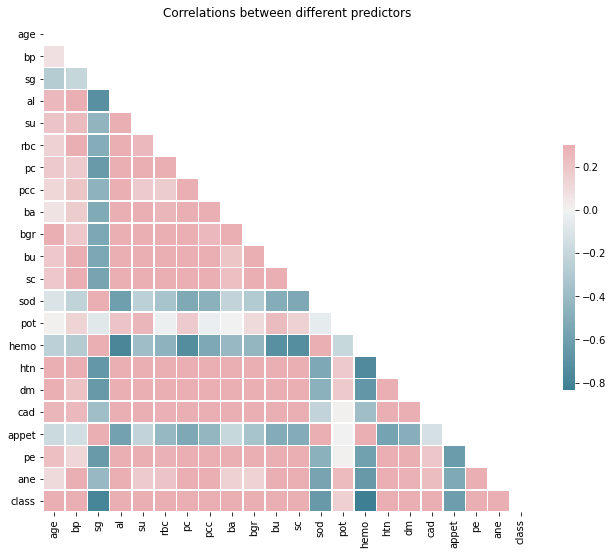

In [11]:
corr_df = df2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations between different predictors')
plt.show()


# Splitting training and testing data


In [12]:
#Giving Train test split rate as 33% for testing and 67% for traning to obtain better accuracy 
X_train, X_test, y_train, y_test = train_test_split(df2.iloc[:,:-1], df2['class'], 
                                                    test_size = 0.33, random_state=44,
                                                   stratify= df2['class'] )

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_train.columns)
print(X_test.columns)

(105, 24)
(53, 24)
(105,)
(53,)
Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane'],
      dtype='object')
Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane'],
      dtype='object')


# Choosing GridSearchCV and 10-fold cross validations with respect to RandomForest Classifier

Detailed classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        39
         1.0       1.00      1.00      1.00        14

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53

Confusion Matrix:
[[39  0]
 [ 0 14]]


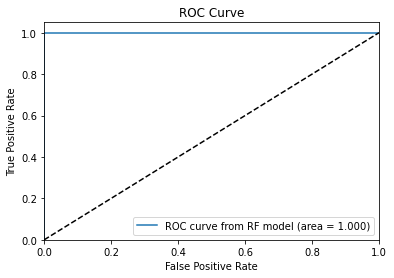

Best parameters:
{'class_weight': None, 'max_depth': 2, 'n_estimators': 8, 'random_state': 42}


In [19]:
tuned_parameters = [{'n_estimators':[7,8,9,10,11,12,13,14,15,16],'max_depth':[2,3,4,5,6,None],
                     'class_weight':[None,{0: 0.33,1:0.67},'balanced'],'random_state':[42]}]
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=10,scoring='f1')

clf.fit(X_train, y_train)

print("Detailed classification report:")
y_true, lr_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

# Determine the false positive and true positive rates
fpr,tpr,roc_auc = auc_scorer(clf, X_test, y_test, 'RF')

print('Best parameters:')
print(clf.best_params_)
clf_best = clf.best_estimator_

# Choosing GridSearchCV  with respect to Support Vector machine from sklearn

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.952, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=1.000, total=   0.2s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=1.000, total=   0.4s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=1.000, total=   0.4s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.952, total=   2.2s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.952, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=1.000, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=1.000, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=1.000, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .

[CV] ..... C=10, gamma=0.01, kernel=linear, score=1.000, total=   0.2s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=1.000, total=   0.4s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=1.000, total=   0.4s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.952, total=   2.1s
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] .... C=10, gamma=0.001, kernel=linear, score=0.952, total=   0.0s
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] .... C=10, gamma=0.001, kernel=linear, score=1.000, total=   0.2s
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] .... C=10, gamma=0.001, kernel=linear, score=1.000, total=   0.4s
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] .

[CV] .. C=1000, gamma=0.001, kernel=linear, score=0.952, total=   1.9s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=0.952, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=1.000, total=   0.2s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=1.000, total=   0.4s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=1.000, total=   0.4s
[CV] C=1000, gamma=0.0001, kernel=linear .............................
[CV] . C=1000, gamma=0.0001, kernel=linear, score=0.952, total=   1.9s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  1.3min finished


Detailed classification report:
              precision    recall  f1-score   support

         0.0       0.60      0.71      0.65        35
         1.0       0.95      0.92      0.93       207

    accuracy                           0.89       242
   macro avg       0.77      0.82      0.79       242
weighted avg       0.90      0.89      0.89       242

Confusion Matrix:
[[ 25  10]
 [ 17 190]]


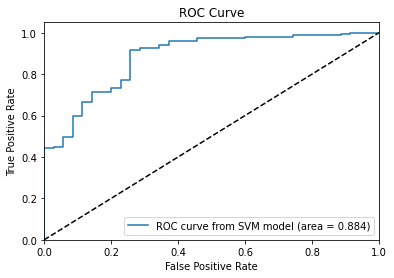

Best parameters:
{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}


In [33]:
from sklearn.svm import SVC
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear']}
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

print("Detailed classification report:")
y1_true, lr1_pred = y_test, grid.predict(X_test)
print(classification_report(y1_true, lr1_pred))

confusion1 = confusion_matrix(y_test, lr1_pred)
print('Confusion Matrix:')
print(confusion1)

# Determine the false positive and true positive rates
fpr1,tpr1,roc_auc1 = auc_scorer(grid, X_test, y_test, 'SVM')

print('Best parameters:')
print(grid.best_params_)
grid_best = grid.best_estimator_

# Feature Extraction with Random Forest

Text(0.5, 1.0, 'Feature Importance')

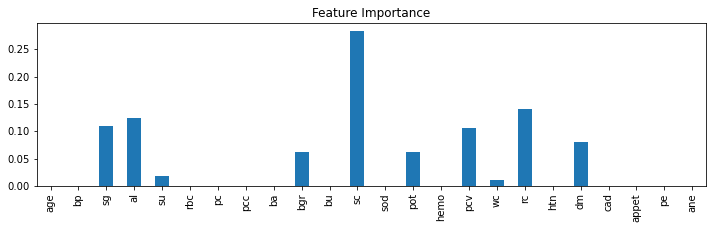

In [20]:
plt.figure(figsize=(12,3))
features = X_test.columns.values.tolist()
importance = clf_best.feature_importances_.tolist()
feature_series = pd.Series(data=importance,index=features)
feature_series.plot.bar()
plt.title('Feature Importance')

# Feature Extraction with Support Vector Machine


Text(0.5, 1.0, 'Feature Importance with SVM')

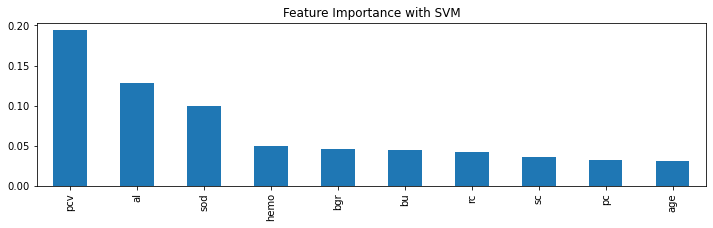

In [36]:
plt.figure(figsize=(12,3))
features1 = X_test.columns.values.tolist()
#importance1 = grid_best.feature_importances_.tolist()
feature_series1 = pd.Series(abs(grid_best.coef_[0]), index=features1).nlargest(10)
#feature_series1 = pd.Series(data=importance1,index=features1)
feature_series1.plot.bar()
plt.title('Feature Importance with SVM')

In [39]:
#Finding out which columns are positive in testing data 
list_to_fill = X_test.columns[feature_series>0]
print(list_to_fill)

Index(['sg', 'al', 'su', 'bgr', 'sc', 'pot', 'pcv', 'wc', 'rc', 'dm'], dtype='object')


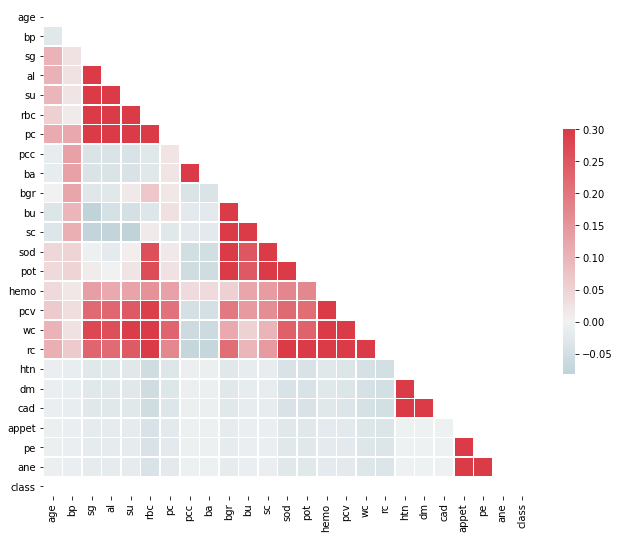

In [22]:
corr_df = pd.isnull(df).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# The above is the arranged data with pre processing and RF

              precision    recall  f1-score   support

         0.0       0.56      1.00      0.72        35
         1.0       1.00      0.87      0.93       207

    accuracy                           0.89       242
   macro avg       0.78      0.93      0.83       242
weighted avg       0.94      0.89      0.90       242

Confusion Matrix:
[[ 35   0]
 [ 27 180]]
Accuracy: 0.888430


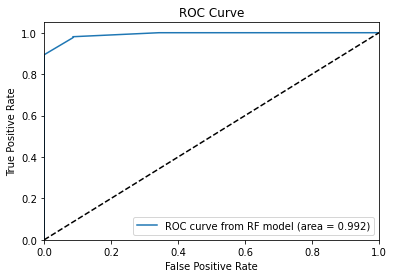

In [25]:
df2 = df.dropna(axis=0)
no_na = df2.index.tolist()
some_na = df.drop(no_na).apply(lambda x: pd.to_numeric(x,errors='coerce'))
some_na = some_na.fillna(0) # Fill up all Nan by zero.

X_test = some_na.iloc[:,:-1]
y_test = some_na['class']
y_true = y_test
lr_pred = clf_best.predict(X_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

print('Accuracy: %3f' % accuracy_score(y_true, lr_pred))
# Determine the false positive and true positive rates
fpr,tpr,roc_auc = auc_scorer(clf_best, X_test, y_test, 'RF')

              precision    recall  f1-score   support

         0.0       0.60      0.71      0.65        35
         1.0       0.95      0.92      0.93       207

    accuracy                           0.89       242
   macro avg       0.77      0.82      0.79       242
weighted avg       0.90      0.89      0.89       242

Confusion Matrix:
[[ 25  10]
 [ 17 190]]
Accuracy: 0.888430


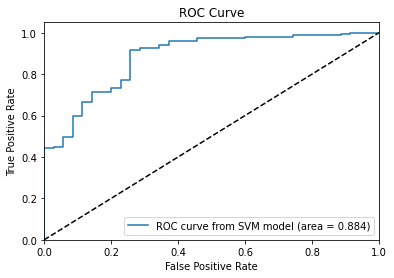

In [41]:
df3 = df.dropna(axis=0)
no_naa = df3.index.tolist()
some_naa = df.drop(no_naa).apply(lambda x: pd.to_numeric(x,errors='coerce'))
some_naa = some_naa.fillna(0) # Fill up all Nan by zero.

X_test = some_na.iloc[:,:-1]
y_test = some_na['class']
y_true = y_test
lr_pred = grid_best.predict(X_test)
print(classification_report(y_true, lr_pred))

confusion = confusion_matrix(y_test, lr_pred)
print('Confusion Matrix:')
print(confusion)

print('Accuracy: %3f' % accuracy_score(y_true, lr_pred))
# Determine the false positive and true positive rates
fpr,tpr,roc_auc = auc_scorer(grid_best, X_test, y_test, 'SVM')

In [15]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np